# Detección de previa de fallos por forma en productos
Se debe tener en cuenta que en una linea de producciónla mayor cantidad de fallos es por la fallas de conformación de un producto. el programa apunta a prerocesar  los productos (conjunto de latas) por imagenes e forma de ubicación en el caso de cara superiro o inferior y lateral  

## 1. Preparación del Entorno en Google Colab

En este primer paso, configuramos el entorno para poder trabajar con TensorFlow y las imágenes almacenadas en Google Drive. Montar Google Drive es un paso fundamental para acceder a los datos sin tener que subirlos en cada sesión.

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Maestria_IA/Modulo 10/proyecto1/sample_can_defects'

if not os.path.exists(data_dir):
    print(f"Error: La carpeta {data_dir} no se encontró.")
else:
    print(f"La carpeta {data_dir} se encontró correctamente.")



Mounted at /content/drive
La carpeta /content/drive/MyDrive/Maestria_IA/Modulo 10/proyecto1/sample_can_defects se encontró correctamente.


## 2. Carga y Aumento de Datos (Data Augmentation)

El `ImageDataGenerator` es una herramienta clave para el preprocesamiento y el aumento de datos.

* **`rescale=1./255`**: Normaliza  `[0, 255]` a `[0, 1]`.
* **`rotation_range`, `width_shift_range`, `height_shift_range`, `shear_range`, `zoom_range`, `horizontal_flip`**: Estas transformaciones geométricas aleatorias crean nuevas versiones de cada imagen de entrenamiento. Esto enriquece el conjunto de datos, hace al modelo más robusto y ayuda a prevenir el sobreajuste (overfitting).
* **`validation_split=0.2`**: Divide tus datos en dos subconjuntos:
80% para entrenamiento
20% para validación
asegurando una evaluación imparcial del modelo durante el entrenamiento.
* **`class_mode='binary'`**: Configura el generador para una clasificación de dos clases, que es exactamente lo que necesitamos para `superior` y `lateral`.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parámetros para el preprocesamiento
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

# Crear un generador de datos con un potente aumento de datos y rescale.
datagen = ImageDataGenerator(
    rescale=1./255, # Normaliza los valores de píxeles a [0, 1]. Esto es crucial.
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Crear los datasets de entrenamiento y validación.
# color_mode='rgb' es necesario para MobileNetV2.
train_ds = datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # <--- Clasificación binaria (2 clases)
    subset='training',
    color_mode='rgb'
)

val_ds = datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # <--- Clasificación binaria (2 clases)
    subset='validation',
    color_mode='rgb'
)

print("Clases inferidas:", train_ds.class_indices)

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Clases inferidas: {'lado': 0, 'super': 1}


## 3. Construcción del Modelo con Transfer Learning

En lugar de entrenar una red neuronal desde cero, utilizamos **Transfer Learning**. Esto significa que tomamos un modelo ya entrenado (`MobileNetV2` en este caso) con un conjunto de datos masivo (`ImageNet`) y lo adaptamos a nuestro problema.

* **`base_model`**: Cargamos MobileNetV2 sin las capas de clasificación superiores (`include_top=False`) y con los pesos de ImageNet (`weights='imagenet'`).
* **`base_model.trainable = False`**: Congelamos los pesos del modelo base. De esta manera, el modelo conserva el conocimiento adquirido de ImageNet.
* **`Sequential`**: Apilamos el modelo base con una nueva capa de clasificación (`Dense(1, activation='sigmoid')`). Para la clasificación binaria, una sola neurona con una función de activación `sigmoid` es todo lo que se necesita. `sigmoid` devuelve un valor entre 0 y 1, que representa la probabilidad de que la imagen pertenezca a la clase 1 (`superior`).
* **`model.compile`**: Compilamos el modelo con el optimizador `Adam` y la función de pérdida `binary_crossentropy`, que es la adecuada para problemas de clasificación binaria.

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# Cargar el modelo base pre-entrenado en ImageNet
# include_top=False: No incluimos las capas de clasificación originales
# weights='imagenet': Usamos los pesos pre-entrenados en ImageNet
base_model = MobileNetV2(
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)

# Congelar el modelo base para que sus pesos no se actualicen durante el entrenamiento
# Esto es clave para el transfer learning en datasets pequeños y acelera mucho el proceso
base_model.trainable = False

# Crear el nuevo modelo secuencial
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), # Aplanamos la salida del modelo base
    Dense(1, activation='sigmoid') # Tu capa de salida para la clasificación binaria (super/lado)
])

# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo para ver la nueva arquitectura
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Entrenamiento y Visualización de Resultados

En este paso, entrenamos el modelo usando los datos generados en el Paso 2. El modelo solo ajustará los pesos de nuestra nueva capa de salida, ya que el modelo base está congelado. Al final, graficamos la precisión y la pérdida para evaluar el rendimiento del entrenamiento y la validación. Lo ideal es que ambas curvas de precisión suban y las de pérdida bajen, sin una gran brecha entre ellas.

In [5]:
# Entrenar el modelo
# Puedes ajustar el número de epochs según el rendimiento del modelo
epochs = 15
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.7316 - loss: 0.4880 - val_accuracy: 0.9125 - val_loss: 0.1842
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9297 - loss: 0.1771 - val_accuracy: 1.0000 - val_loss: 0.0572
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9920 - loss: 0.0577 - val_accuracy: 1.0000 - val_loss: 0.0316
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9988 - loss: 0.0311 - val_accuracy: 1.0000 - val_loss: 0.0241
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.9979 - loss: 0.0336 - val_accuracy: 1.0000 - val_loss: 0.0187
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.9966 - loss: 0.0311 - val_accuracy: 1.0000 - val_loss: 0.0152
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.9966 - loss: 0.0304 - val_accuracy: 1.0000 - val_loss: 0.0123
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9914 - loss: 0.0541 - val_accuracy: 1.0000 - val_loss:

## 5. Clasificación y Organización de Imágenes de Prueba

Finalmente, usaremos el modelo entrenado para clasificar un conjunto de imágenes de prueba no etiquetadas. El código a continuación no solo clasifica cada imagen, sino que también las organiza moviéndolas a subcarpetas llamadas `superior` o `lateral` dentro de la carpeta `test`. Esto es útil para una verificación manual y rápida de los resultados.

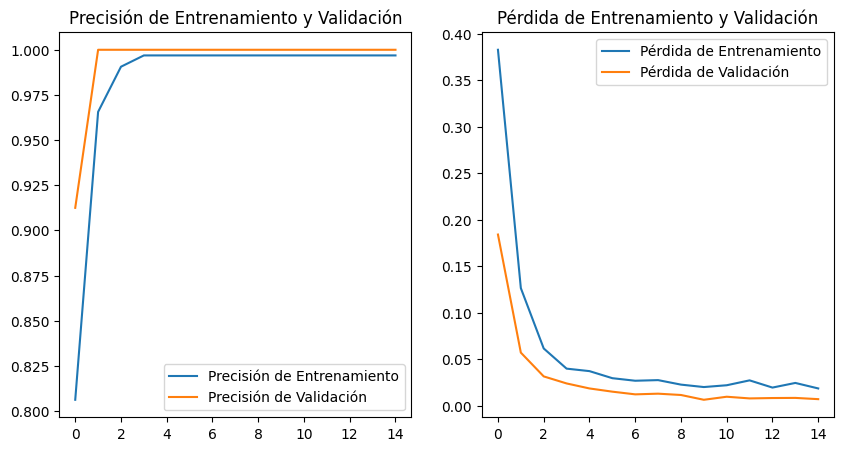

In [6]:
# Gráfica de la precisión y la pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión de Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de Validación')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')
plt.show()

In [7]:
from tensorflow.keras.preprocessing import image

def clasificar_imagen(path_de_imagen):
    # Cargar y redimensionar la imagen
    img = image.load_img(path_de_imagen, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)

    # Añadir una dimensión de batch y normalizar
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Realizar la predicción
    prediction = model.predict(img_array)[0][0]

    # Interpretar el resultado
    class_labels = list(train_ds.class_indices.keys())
    if prediction > 0.5:
        clase_predicha = class_labels[1] # La clase con índice 1
        confianza = prediction
    else:
        clase_predicha = class_labels[0] # La clase con índice 0
        confianza = 1 - prediction

    print(f"La imagen se clasificó como '{clase_predicha}' con una confianza del {confianza * 100:.2f}%")
    return clase_predicha


In [13]:
import os
import shutil  # Biblioteca para mover y copiar archivos
import numpy as np
from tensorflow.keras.preprocessing import image

# Definir las rutas
test_dir = '/content/drive/MyDrive/Maestria_IA/Modulo 10/reserva/test/test'

# Definir las carpetas de destino basadas en las clases de tu modelo
# Es crucial que estos nombres coincidan con las etiquetas de tu modelo.
class_labels = list(train_ds.class_indices.keys())
output_dir_0 = os.path.join(test_dir, class_labels[0]) # Probablemente 'lado' o 'superior'
output_dir_1 = os.path.join(test_dir, class_labels[1]) # El otro

# Crear las carpetas de destino si no existen
os.makedirs(output_dir_0, exist_ok=True)
os.makedirs(output_dir_1, exist_ok=True)

print(f"Las imágenes se clasificarán y guardarán en:\n- {output_dir_0}\n- {output_dir_1}")

def clasificar_y_guardar_imagenes(carpeta_origen, carpeta_destino_0, carpeta_destino_1):

    #Clasifica todas las imágenes en una carpeta y las guarda en subcarpetas.
    total_imagenes = 0

    # Recorrer los archivos en la carpeta de origen
    for file in os.listdir(carpeta_origen):
        img_path = os.path.join(carpeta_origen, file)

        # Asegurarse de que sea un archivo de imagen
        if os.path.isfile(img_path) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
            total_imagenes += 1

            # Predecir la clase de la imagen
            img = image.load_img(img_path, target_size=IMAGE_SIZE, color_mode='rgb')
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            prediction = model.predict(img_array, verbose=0)[0][0]

            # Mover la imagen según la predicción
            if prediction > 0.5:
                # La predicción es la clase 1 (ej: 'superior')
                shutil.copy(img_path, os.path.join(carpeta_destino_1, file))
                clase_predicha = class_labels[1]
            else:
                # La predicción es la clase 0 (ej: 'lateral')
                shutil.copy(img_path, os.path.join(carpeta_destino_0, file))
                clase_predicha = class_labels[0]

            print(f"Imagen '{file}' clasificada como '{clase_predicha}' y movida.")

    print(f"\nProceso completado. Se clasificaron {total_imagenes} imágenes.")

# Ejecutar la clasificación y el guardado
clasificar_y_guardar_imagenes(test_dir, output_dir_0, output_dir_1)

Las imágenes se clasificarán y guardarán en:
- /content/drive/MyDrive/Maestria_IA/Modulo 10/reserva/test/test/lado
- /content/drive/MyDrive/Maestria_IA/Modulo 10/reserva/test/test/super
Imagen 'IMG_20220929_131519_jpg.rf.384bdea53267596695803e9981b5d486.jpg' clasificada como 'super' y movida.
Imagen 'IMG_20221108_111204_jpg.rf.6cce49d858c772cb49cf75b83f73c964.jpg' clasificada como 'lado' y movida.
Imagen 'IMG_20220929_114034_jpg.rf.a4e65d31f383de0d971d03ddd09b971c.jpg' clasificada como 'lado' y movida.
Imagen 'IMG_20220925_135156_jpg.rf.e4ff9d7cb7d74837d5cc1c51025301ed.jpg' clasificada como 'lado' y movida.
Imagen 'IMG_20221108_112109_jpg.rf.7e2a5f22057fc80b916cd3cbcc5ba06a.jpg' clasificada como 'lado' y movida.
Imagen 'IMG_20220924_012047_jpg.rf.2a85ca1d96f7d111b9fd6231b7d73d3f.jpg' clasificada como 'lado' y movida.
Imagen 'IMG_20221108_090811_jpg.rf.1a5e1072936e366bdba1f3928ad30261.jpg' clasificada como 'lado' y movida.
Imagen 'IMG_20221108_091810_jpg.rf.09f283779e7a7123a104928e220c0

In [11]:
# Guarda el modelo en el formato HDF5 (.h5) para máxima compatibilidad.
# Iincluye la arquitectura, los pesos y el estado del optimizador.
nombre_del_modelo = 'modelo_clasificador_latas.h5'
model.save(nombre_del_modelo)

print(f"Modelo guardado como '{nombre_del_modelo}'")

Modelo guardado como 'modelo_clasificador_latas.h5'


ver el tamaño

In [12]:
import os

# Ruta donde se guardó el modelo
ruta_del_modelo = nombre_del_modelo  # O 'nombre_del_modelo_keras'

# Obtener el tamaño del archivo en bytes
tamano_bytes = os.path.getsize(ruta_del_modelo)

# Convertir a megabytes (MB) para una lectura más fácil
tamano_mb = tamano_bytes / (1024 * 1024)

print(f"El modelo '{ruta_del_modelo}' ocupa: {tamano_mb:.2f} MB en disco.")

El modelo 'modelo_clasificador_latas.h5' ocupa: 8.98 MB en disco.
